<a href="https://colab.research.google.com/github/alcj17/PucRio/blob/main/mvp_analise_pedidos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP de Análise de Dados e Boas Práticas**

# Sprint: Análise de Dados e Boas Práticas (40530010055_20240_01)

## Profs. Tatiana Escovedo e Hugo Villamizar

#### Por: Antonio Lacerda de Castro Junior


# Introdução


# Objetivo

## 1. Definição do Problema

  A companhia decidiu entender a distribuição de pedidos por data e seus status a partir de 01/01/2024 em todos os Centro de Distribuição, e neste primeiro ensaio visualizando apenas as quantidades de pedidos sem precisar ver os principais pontos de saídas de entregas.
  Seu objetivo é saber a curto prazo dentro um espaço de 8 meses se a volumetria de pedidos está em uma crescente, estável ou em queda, e seu compartamento dentro de um SLA logístico através de seus status.
  O Dataset é uma pequena fração de dados dos pedidos diários compostos de de informações de data de criação, status, saída em roteiros, acompanhamento de suas etapas sofridas nas entregas até sua definição de concluído ou não e assim ver tempo de criação do pedido e encerramento.
  Seus atributos são capazes de mostrar através de uma linha de tempo situações e mudanças do pedido e poder prever se existe algum ganho no processo de entrega e inclusive com algumas classificações e regiões de entrega.
  Neste contexto separamos uma pequena amostra de 6.289.739 milhões de registros.

## 2. Atributos
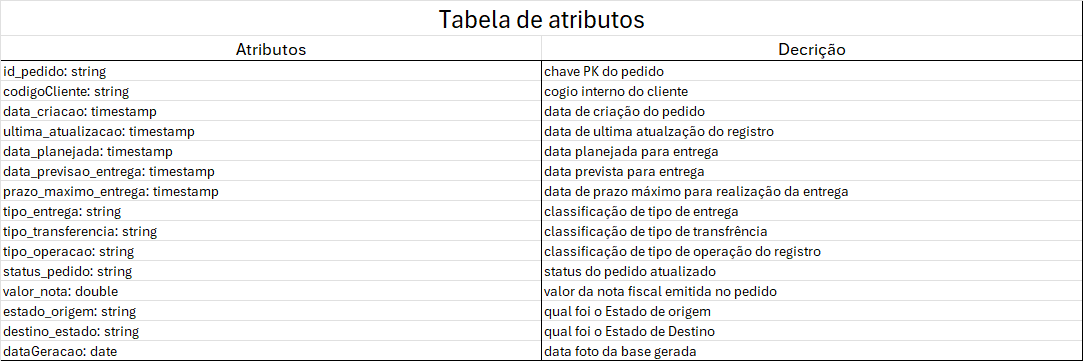


## Etapas do Projeto

## 3. Configurando o ambiente
primeiro passo é instalar o pyspark para poder realizar processamentos mais rápidos

In [1]:
# Instalando o pyspark
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


 Após a instalação do pyspark o drive será montado no google drive ond eestão as bases que serão usadas no projeto.

## 3.1 Preparando o ambiente spark
abaixo vamos criar uma sessão do spark para poder concentrar recursos e usar melhoro ambiente

In [2]:
# Importar a biblioteca drive
import pyspark
import pandas as pd
from google.colab import drive

from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# Inicializa a sessão Spark
spark = SparkSession.builder \
    .appName("Importando Bases") \
    .getOrCreate()

## 3.2 Montando a conexão com o google drive

Aqui vamos buscar as bases no google drive realizando a montagem através da biblioteca já carregada anteriormente - google.colab

In [3]:
# Montar o Google Drive
drive.mount('/content/drive')

# Definindo caminho da base de Pedidos
file_path = '/content/drive/My Drive/mvp/bases/base_pedido_com_tipos.csv'

# o link acima é de acesso público , abaixo segue link original
# base pedidos
# https://drive.google.com/drive/folders/1BC-uXOhjgJoPpJf8YQ15rEZqUDIVY5IJ?usp=sharing

# base pedidos com tipos original:
# link: https://drive.google.com/file/d/1Ru8kVfnHc3BZRSrXargjW8VCZec6-L5Q/view?usp=drive_link

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.3 Lendo e carregando os dados em um dataframe pyspark

In [4]:
# Carregar o arquivo CSV em um DataFrame PySpark
df_pedidos = spark.read.csv(file_path, header=True, inferSchema=True, sep=";")

## 3.4 Verificando a volumetria da análise

In [5]:
# analisando qual a volumteria que tem na massa de análise
print("total> "+str(df_pedidos.count()))

total> 6289739


## 3.5 Verificando os tipos de dados através do schema

In [6]:
df_pedidos.printSchema()

root
 |-- id_pedido: string (nullable = true)
 |-- codigoCliente: string (nullable = true)
 |-- data_criacao: timestamp (nullable = true)
 |-- ultima_atualizacao: timestamp (nullable = true)
 |-- data_planejada: timestamp (nullable = true)
 |-- data_previsao_entrega: timestamp (nullable = true)
 |-- prazo_maximo_entrega: timestamp (nullable = true)
 |-- tipo_entrega: string (nullable = true)
 |-- tipo_transferencia: string (nullable = true)
 |-- tipo_operacao: string (nullable = true)
 |-- status_pedido: string (nullable = true)
 |-- valor_nota: double (nullable = true)
 |-- estado_origem: string (nullable = true)
 |-- destino_estado: string (nullable = true)
 |-- dataGeracao: date (nullable = true)



Reduzindo a massa para entender os dados contidos para análise com base na coluna de data que vou usar na minha análise.

In [7]:
# Exibir as primeiras linhas do resultado
df_pedidos = df_pedidos.filter(col("Data_Criacao")>="2024-08-01")

## 3.6 Convertendo para o Pandas

In [8]:
# verificando se o filtro foi eficiente mostrando as datas mínima e máxima dentro do dataframe
min_date = df_pedidos.agg(F.min("Data_Criacao")).collect()[0][0]
max_date = df_pedidos.agg(F.max("Data_Criacao")).collect()[0][0]

print("Data mínima:", min_date)
print("Data máxima:", max_date)

# particionando o dataframe para a conversão ser mais rápida
df_Spark = df_pedidos.repartition(20)

# criando campos de Ano, mês e dia como Integer para análises focadas nas datas
df_Spark = df_Spark.withColumn("Ano", F.year("Data_Criacao"))
df_Spark = df_Spark.withColumn("Mes", F.month("Data_Criacao"))
df_Spark = df_Spark.withColumn("Dia", F.dayofmonth("Data_Criacao"))

# convertendo para o Pandas
df_pandas = df_Spark.toPandas()

Data mínima: 2024-08-01 00:00:09.067000
Data máxima: 2024-09-14 15:40:52.935000


## 3.7 Analisando meus Dados e metadados com o Pandas

In [9]:
# verificando o uso de memória por coluna em sua massa bruta
memory_usage_per_column = df_pandas.memory_usage(deep=True)
print(memory_usage_per_column)

# analisando minhas colunas e seus tipos
df_pandas.info()

Index                          128
id_pedido                106869699
codigoCliente            106869699
data_criacao              10555032
ultima_atualizacao        10555032
data_planejada            10555032
data_previsao_entrega     10555032
prazo_maximo_entrega      10555032
tipo_entrega              83671269
tipo_transferencia        88998300
tipo_operacao             83181228
status_pedido             86331834
valor_nota                10555032
estado_origem             77843361
destino_estado            77843361
dataGeracao               52775160
Ano                        5277516
Mes                        5277516
Dia                        5277516
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319379 entries, 0 to 1319378
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id_pedido              1319379 non-null  object        
 1   codigoCliente        

## 4 Preparação dos Dados:
Reduzir o uso de memória e ajustar os tipos de dados para iniciar a análise.

1 - Os campos de datas estão como Object,
 então preciso converter para date mesmo que seu dados já estejam em formato de data

In [10]:
# convertendo as colunas data que estão como object
df_pandas['dataGeracao'] = pd.to_datetime(df_pandas['dataGeracao'])

2 - Agora vamos converter todas as colunas que estão como Object e não pertencem a outro tipo de dado

In [11]:
# usando um for para percorrer todas as colunas e ajustar os tipos para Category e assim economizar memória
for col in df_pandas.select_dtypes(include='object').columns:
    df_pandas[col] = df_pandas[col].astype('category')

# as colunas id_pedido e identificacaoCliente ficaram como object pois serão descartadas em breve
# convertendo de volta as colunas que serão expurgadas da análise
df_pandas['id_pedido'] = df_pandas['id_pedido'].astype('object')

3 - Agora vamos observar o ganho de perfomance para realização da análise.

In [12]:
memory_usage_per_column = df_pandas.memory_usage(deep=True)
print(memory_usage_per_column)

df_pandas.info()

# observe no resultado e compare com o outro de verificação de uso de memória acima
# e vai ver que houveram grandes ganhos inclusive no uso de memória no geral que caiu quase 50%

Index                          128
id_pedido                106869699
codigoCliente              2945092
data_criacao              10555032
ultima_atualizacao        10555032
data_planejada            10555032
data_previsao_entrega     10555032
prazo_maximo_entrega      10555032
tipo_entrega               1319615
tipo_transferencia         1320275
tipo_operacao              1319934
status_pedido              1321366
valor_nota                10555032
estado_origem              1321292
destino_estado             1322044
dataGeracao               10555032
Ano                        5277516
Mes                        5277516
Dia                        5277516
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319379 entries, 0 to 1319378
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id_pedido              1319379 non-null  object        
 1   codigoCliente        

In [13]:
# volumetria por colunas
df_pandas.count()


,0
id_pedido,1319379
codigoCliente,1319379
data_criacao,1319379
ultima_atualizacao,1319379
data_planejada,375064
data_previsao_entrega,20236
prazo_maximo_entrega,1110517
tipo_entrega,1319379
tipo_transferencia,1107334
tipo_operacao,1319379


In [14]:
# sumário estatístico
df_pandas.describe()

,data_criacao,ultima_atualizacao,data_planejada,data_previsao_entrega,prazo_maximo_entrega,valor_nota,dataGeracao,Ano,Mes,Dia
count,1319379,1319379,375064,20236,1110517,1.319377e+06,1319379,1319379.0,1.319379e+06,1.319379e+06
mean,2024-08-22 05:02:09.725229824,2024-08-25 17:17:53.784981760,2024-08-24 19:37:02.537383424,2024-09-02 11:19:19.913026816,2024-08-25 02:56:45.199904,1.344907e+03,2024-09-14 00:00:00,2024.0,8.265896e+00,1.331814e+01
min,2024-08-01 00:00:09.067000,2024-08-01 01:07:09.665000,2024-07-23 03:00:00,2022-09-23 03:00:00,2024-07-19 03:00:00,0.000000e+00,2024-09-14 00:00:00,2024.0,8.000000e+00,1.000000e+00
25%,2024-08-11 14:15:42.580499968,2024-08-14 00:41:17.480500224,2024-08-13 03:00:00,2024-08-27 03:00:00,2024-08-13 03:00:00,3.289000e+02,2024-09-14 00:00:00,2024.0,8.000000e+00,7.000000e+00
50%,2024-08-20 21:40:31.631000064,2024-08-23 21:37:21.822000128,2024-08-24 06:43:36.489999872,2024-09-04 03:00:00,2024-08-24 03:00:00,9.990000e+02,2024-09-14 00:00:00,2024.0,8.000000e+00,1.200000e+01
75%,2024-09-02 15:44:05.412499968,2024-09-06 15:23:24.253000192,2024-09-05 14:40:06.441500160,2024-09-11 03:00:00,2024-09-06 03:00:00,1.917600e+03,2024-09-14 00:00:00,2024.0,9.000000e+00,2.000000e+01
max,2024-09-14 15:40:52.935000,2024-09-14 15:42:57.830000,2024-11-04 03:00:00,2024-10-03 03:00:00,2024-11-04 03:00:00,6.549480e+04,2024-09-14 00:00:00,2024.0,9.000000e+00,3.100000e+01
std,NaN,NaN,NaN,NaN,NaN,1.397836e+03,NaN,0.0,4.418091e-01,8.116272e+00


In [15]:
# ordenando pela data de criação do pedido
df_pandas = df_pandas.sort_values(by='data_criacao')

## 4.1 Preparação e Transformação das colunas vazias ou nulas

In [16]:
# Primeria lista de colunas para ajustes
colunas_para_ajustar = ['status_pedido']

# Adicionar a nova categoria 'SEM STATUS' em cada coluna, se ela for categórica
for coluna in colunas_para_ajustar:
    # Se a coluna for categórica, adicionar a categoria 'SEM STATUS' se ainda não estiver presente
    if df_pandas[coluna].dtype.name == 'category':
        if 'SEM STATUS' not in df_pandas[coluna].cat.categories:
            df_pandas[coluna] = df_pandas[coluna].cat.add_categories('SEM STATUS')

    # Substituindo valores nulos ou vazios por 'SEM STATUS'
    df_pandas[coluna] = df_pandas[coluna].replace('', None)
    df_pandas[coluna] = df_pandas[coluna].fillna('SEM STATUS')

# Segunda lista de colunas para ajustes
colunas_para_ajustar = ['tipo_entrega','tipo_transferencia','tipo_operacao','estado_origem','destino_estado']

# Adicionar a nova categoria 'SEM STATUS' em cada coluna, se ela for categórica
for coluna in colunas_para_ajustar:
    # Se a coluna for categórica, adicionar a categoria 'NÃO INFORMADO' se ainda não estiver presente
    if df_pandas[coluna].dtype.name == 'category':
        if 'NÃO INFORMADO' not in df_pandas[coluna].cat.categories:
            df_pandas[coluna] = df_pandas[coluna].cat.add_categories('NÃO INFORMADO')

    # Substituir valores nulos ou vazios por 'NÃO INFORMADO'
    df_pandas[coluna] = df_pandas[coluna].replace('', None)
    df_pandas[coluna] = df_pandas[coluna].fillna('NÃO INFORMADO')

# Lista de colunas de data que precisam ser preenchidas
colunas_data = ['prazo_maximo_entrega', 'data_previsao_entrega', 'data_planejada', 'ultima_atualizacao']

# Preencher as colunas de data com os valores da coluna 'Data_Criacao' onde houver valores nulos
for coluna in colunas_data:
    df_pandas[coluna] = df_pandas[coluna].fillna(df_pandas['data_criacao'])

# Ajustando todos os valores da coluna 'Concluido' para letras maiúsculas
df_pandas['tipo_entrega'] = df_pandas['tipo_entrega'].str.upper()
df_pandas['tipo_transferencia'] = df_pandas['tipo_transferencia'].str.upper()
df_pandas['tipo_operacao'] = df_pandas['tipo_operacao'].str.upper()
df_pandas['status_pedido'] = df_pandas['status_pedido'].str.upper()
df_pandas['estado_origem'] = df_pandas['estado_origem'].str.upper()
df_pandas['destino_estado'] = df_pandas['destino_estado'].str.upper()

# Preencher valores NaN com 0 o campo Ordem
df_pandas['valor_nota'] = df_pandas['valor_nota'].fillna(0)

# Verificar o dataframe
display(df_pandas)


,id_pedido,codigoCliente,data_criacao,ultima_atualizacao,data_planejada,data_previsao_entrega,prazo_maximo_entrega,tipo_entrega,tipo_transferencia,tipo_operacao,status_pedido,valor_nota,estado_origem,destino_estado,dataGeracao,Ano,Mes,Dia
739478,66aad0099fad51562a14acff,6573094357494271414bf9d0,2024-08-01 00:00:09.067,2024-08-15 23:07:32.587,2024-08-09 03:00:00.000,2024-08-01 00:00:09.067,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,545.01,SP,CE,2024-09-14,2024,8,1
1200698,66aad01331284c60c6c4218e,6573094357494271414bf9d0,2024-08-01 00:00:19.691,2024-08-02 19:19:02.025,2024-08-02 03:00:00.000,2024-08-01 00:00:19.691,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,74.36,SP,SP,2024-09-14,2024,8,1
478068,66aad01c31284c60c6c42196,6573094357494271414bf9d0,2024-08-01 00:00:28.859,2024-08-10 19:09:13.130,2024-08-09 03:00:00.000,2024-08-01 00:00:28.859,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,305.10,SP,PE,2024-09-14,2024,8,1
808471,66aad0259fad51562a14ad05,6573094357494271414bf9d0,2024-08-01 00:00:37.420,2024-08-02 15:18:41.413,2024-08-02 03:00:00.000,2024-08-01 00:00:37.420,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,495.00,SP,SP,2024-09-14,2024,8,1
806292,66aad0259fad51562a14ad07,60f3fe1ea1a5670001e6f346,2024-08-01 00:00:37.854,2024-08-01 08:41:00.399,2024-08-01 00:00:37.854,2024-08-01 00:00:37.854,2024-08-02 03:00:00,NORMAL,SEM_TRANSFERENCIA,DIRETO,ENTREGUE,0.00,SP,SP,2024-09-14,2024,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866228,66e5ae44b807dd4ecd008233,64de0b07aaa0512a4196038b,2024-09-14 15:39:48.564,2024-09-14 15:39:49.054,2024-09-23 03:00:00.000,2024-09-14 15:39:48.564,2024-09-23 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,PLANEJADA,79.90,ES,RJ,2024-09-14,2024,9,14
797583,66e5ae55dcbcf62e49935a1f,5f58daaa7364f937fc5782cb,2024-09-14 15:40:05.693,2024-09-14 15:40:07.690,2024-09-14 15:40:07.290,2024-09-14 15:40:05.693,2024-09-16 03:00:00,SAME_DAY,SEM_TRANSFERENCIA,MINIHUB_VV,PLANEJADA,279.99,SP,SP,2024-09-14,2024,9,14
8385,66e5ae55dcbcf62e49935a20,600aca467364f9664826b067,2024-09-14 15:40:05.706,2024-09-14 15:40:07.716,2024-09-14 15:40:07.325,2024-09-14 15:40:05.706,2024-09-16 03:00:00,SAME_DAY,SEM_TRANSFERENCIA,MINIHUB_VV,PLANEJADA,251.57,SP,SP,2024-09-14,2024,9,14
10737,66e5ae714509ed4ddbe12e71,60f84d6aa1a5670001ead25b,2024-09-14 15:40:33.536,2024-09-14 15:40:36.752,2024-09-14 15:40:33.536,2024-09-14 15:40:33.536,2024-09-16 03:00:00,NORMAL,SEM_TRANSFERENCIA,DIRETO,EM_LAST_MILE,3329.91,RJ,RJ,2024-09-14,2024,9,14


# 5 Analisando Dados

In [17]:
# mostrando dimensões do dataset
print(df_pandas.shape)

(1319379, 18)


In [18]:
# informações do conjunto
print(df_pandas.info())

# pode-se observar que as colunas de categoria já foram definidas separando assim de forma mais simples dos campos que serão usados como métricas ou base de cálculos.

<class 'pandas.core.frame.DataFrame'>
Index: 1319379 entries, 739478 to 802962
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id_pedido              1319379 non-null  object        
 1   codigoCliente          1319379 non-null  category      
 2   data_criacao           1319379 non-null  datetime64[ns]
 3   ultima_atualizacao     1319379 non-null  datetime64[ns]
 4   data_planejada         1319379 non-null  datetime64[ns]
 5   data_previsao_entrega  1319379 non-null  datetime64[ns]
 6   prazo_maximo_entrega   1319379 non-null  datetime64[ns]
 7   tipo_entrega           1319379 non-null  object        
 8   tipo_transferencia     1319379 non-null  object        
 9   tipo_operacao          1319379 non-null  object        
 10  status_pedido          1319379 non-null  object        
 11  valor_nota             1319379 non-null  float64       
 12  estado_origem          131937

In [19]:
# mostrando as 5 primeiras linhas
df_pandas.head(5)

,id_pedido,codigoCliente,data_criacao,ultima_atualizacao,data_planejada,data_previsao_entrega,prazo_maximo_entrega,tipo_entrega,tipo_transferencia,tipo_operacao,status_pedido,valor_nota,estado_origem,destino_estado,dataGeracao,Ano,Mes,Dia
739478,66aad0099fad51562a14acff,6573094357494271414bf9d0,2024-08-01 00:00:09.067,2024-08-15 23:07:32.587,2024-08-09 03:00:00.000,2024-08-01 00:00:09.067,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,545.01,SP,CE,2024-09-14,2024,8,1
1200698,66aad01331284c60c6c4218e,6573094357494271414bf9d0,2024-08-01 00:00:19.691,2024-08-02 19:19:02.025,2024-08-02 03:00:00.000,2024-08-01 00:00:19.691,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,74.36,SP,SP,2024-09-14,2024,8,1
478068,66aad01c31284c60c6c42196,6573094357494271414bf9d0,2024-08-01 00:00:28.859,2024-08-10 19:09:13.130,2024-08-09 03:00:00.000,2024-08-01 00:00:28.859,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,305.10,SP,PE,2024-09-14,2024,8,1
808471,66aad0259fad51562a14ad05,6573094357494271414bf9d0,2024-08-01 00:00:37.420,2024-08-02 15:18:41.413,2024-08-02 03:00:00.000,2024-08-01 00:00:37.420,2024-08-08 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,ENTREGUE,495.00,SP,SP,2024-09-14,2024,8,1
806292,66aad0259fad51562a14ad07,60f3fe1ea1a5670001e6f346,2024-08-01 00:00:37.854,2024-08-01 08:41:00.399,2024-08-01 00:00:37.854,2024-08-01 00:00:37.854,2024-08-02 03:00:00,NORMAL,SEM_TRANSFERENCIA,DIRETO,ENTREGUE,0.00,SP,SP,2024-09-14,2024,8,1


In [20]:
# mostrando as 5 ultimas linhas
df_pandas.tail(5)

,id_pedido,codigoCliente,data_criacao,ultima_atualizacao,data_planejada,data_previsao_entrega,prazo_maximo_entrega,tipo_entrega,tipo_transferencia,tipo_operacao,status_pedido,valor_nota,estado_origem,destino_estado,dataGeracao,Ano,Mes,Dia
866228,66e5ae44b807dd4ecd008233,64de0b07aaa0512a4196038b,2024-09-14 15:39:48.564,2024-09-14 15:39:49.054,2024-09-23 03:00:00.000,2024-09-14 15:39:48.564,2024-09-23 03:00:00,NORMAL,TRANSFERENCIA_UX,ENVVIAS,PLANEJADA,79.90,ES,RJ,2024-09-14,2024,9,14
797583,66e5ae55dcbcf62e49935a1f,5f58daaa7364f937fc5782cb,2024-09-14 15:40:05.693,2024-09-14 15:40:07.690,2024-09-14 15:40:07.290,2024-09-14 15:40:05.693,2024-09-16 03:00:00,SAME_DAY,SEM_TRANSFERENCIA,MINIHUB_VV,PLANEJADA,279.99,SP,SP,2024-09-14,2024,9,14
8385,66e5ae55dcbcf62e49935a20,600aca467364f9664826b067,2024-09-14 15:40:05.706,2024-09-14 15:40:07.716,2024-09-14 15:40:07.325,2024-09-14 15:40:05.706,2024-09-16 03:00:00,SAME_DAY,SEM_TRANSFERENCIA,MINIHUB_VV,PLANEJADA,251.57,SP,SP,2024-09-14,2024,9,14
10737,66e5ae714509ed4ddbe12e71,60f84d6aa1a5670001ead25b,2024-09-14 15:40:33.536,2024-09-14 15:40:36.752,2024-09-14 15:40:33.536,2024-09-14 15:40:33.536,2024-09-16 03:00:00,NORMAL,SEM_TRANSFERENCIA,DIRETO,EM_LAST_MILE,3329.91,RJ,RJ,2024-09-14,2024,9,14
802962,66e5ae844509ed4ddbe12e83,60df30f9908ff80001bfc17e,2024-09-14 15:40:52.935,2024-09-14 15:40:55.901,2024-09-14 15:40:52.935,2024-09-14 15:40:52.935,2024-09-17 03:00:00,NORMAL,SEM_TRANSFERENCIA,DIRETO,EM_LAST_MILE,0.00,MG,MG,2024-09-14,2024,9,14


In [21]:
# observando os tipos de cada atributo
df_pandas.dtypes

,0
id_pedido,object
codigoCliente,category
data_criacao,datetime64[ns]
ultima_atualizacao,datetime64[ns]
data_planejada,datetime64[ns]
data_previsao_entrega,datetime64[ns]
prazo_maximo_entrega,datetime64[ns]
tipo_entrega,object
tipo_transferencia,object
tipo_operacao,object


In [22]:
# aplicando a técnica do describe para entender alguns campos chaves para análise - média, desvio padrão, mínimo, máximo e os trimestres
df_pandas.describe()

,data_criacao,ultima_atualizacao,data_planejada,data_previsao_entrega,prazo_maximo_entrega,valor_nota,dataGeracao,Ano,Mes,Dia
count,1319379,1319379,1319379,1319379,1319379,1.319379e+06,1319379,1319379.0,1.319379e+06,1.319379e+06
mean,2024-08-22 05:02:09.725229824,2024-08-25 17:17:53.784981760,2024-08-22 12:13:13.142054912,2024-08-22 05:46:52.527498752,2024-08-23 16:30:06.818395904,1.344905e+03,2024-09-14 00:00:00,2024.0,8.265896e+00,1.331814e+01
min,2024-08-01 00:00:09.067000,2024-08-01 01:07:09.665000,2024-07-23 03:00:00,2022-09-23 03:00:00,2024-07-19 03:00:00,0.000000e+00,2024-09-14 00:00:00,2024.0,8.000000e+00,1.000000e+00
25%,2024-08-11 14:15:42.580499968,2024-08-14 00:41:17.480500224,2024-08-11 16:05:52.452000,2024-08-11 14:15:53.236000256,2024-08-12 19:18:51.928499968,3.289000e+02,2024-09-14 00:00:00,2024.0,8.000000e+00,7.000000e+00
50%,2024-08-20 21:40:31.631000064,2024-08-23 21:37:21.822000128,2024-08-21 03:00:00,2024-08-20 21:41:16.168999936,2024-08-22 03:00:00,9.990000e+02,2024-09-14 00:00:00,2024.0,8.000000e+00,1.200000e+01
75%,2024-09-02 15:44:05.412499968,2024-09-06 15:23:24.253000192,2024-09-02 21:34:07.953499904,2024-09-02 16:56:27.270999808,2024-09-04 03:00:00,1.917600e+03,2024-09-14 00:00:00,2024.0,9.000000e+00,2.000000e+01
max,2024-09-14 15:40:52.935000,2024-09-14 15:42:57.830000,2024-11-04 03:00:00,2024-10-03 03:00:00,2024-11-04 03:00:00,6.549480e+04,2024-09-14 00:00:00,2024.0,9.000000e+00,3.100000e+01
std,NaN,NaN,NaN,NaN,NaN,1.397836e+03,NaN,0.0,4.418091e-01,8.116272e+00


In [23]:
# agora vamos analisar o balanceamento de acordo com o destino dos pedidos
print(df_pandas.groupby('destino_estado').size())

destino_estado
AC        17
AL     11576
AM      5559
AP        27
BA     68598
CE     31515
DF     22730
ES     21139
GO     28084
MA     12011
MG    163736
MS     13213
MT      5491
PA     14926
PB     12676
PE     30929
PI      6689
PR     58074
RJ    233271
RN     11245
RO        40
RR        14
RS     39304
SC     18986
SE      8957
SP    497270
TO      3302
dtype: int64


In [24]:
# agora vamos mostrar em percentual a mesma análise acima e classificando do maior para o menor
# Contagem por estado
contagem = df_pandas['destino_estado'].value_counts()

# Calcular percentual
percentual = (contagem / contagem.sum()) * 100

# Formatar para exibir valores com símbolo de percentual
percentual_formatado = percentual.map("{:.2f}%".format)

# Exibir resultado
print(percentual_formatado)

destino_estado
SP    37.69%
RJ    17.68%
MG    12.41%
BA     5.20%
PR     4.40%
RS     2.98%
CE     2.39%
PE     2.34%
GO     2.13%
DF     1.72%
ES     1.60%
SC     1.44%
PA     1.13%
MS     1.00%
PB     0.96%
MA     0.91%
AL     0.88%
RN     0.85%
SE     0.68%
PI     0.51%
AM     0.42%
MT     0.42%
TO     0.25%
RO     0.00%
AP     0.00%
AC     0.00%
RR     0.00%
Name: count, dtype: object


# 5.1 Visualiando Dados

Para esta estapa vou remover algumas colunas que certamente vão desfigurar os gráficos trazendo confusão as análises

In [25]:
# configurando o ambiente
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix

In [26]:
# selecionando campos para o Histograma

df_historgrama = df_pandas[['id_pedido','codigoCliente','tipo_entrega','tipo_transferencia','tipo_operacao','status_pedido','valor_nota','estado_origem','destino_estado','Mes']]

array([[<Axes: title={'center': 'data_criacao'}>,
        <Axes: title={'center': 'ultima_atualizacao'}>,
        <Axes: title={'center': 'data_planejada'}>],
       [<Axes: title={'center': 'data_previsao_entrega'}>,
        <Axes: title={'center': 'prazo_maximo_entrega'}>,
        <Axes: title={'center': 'valor_nota'}>],
       [<Axes: title={'center': 'dataGeracao'}>,
        <Axes: title={'center': 'Ano'}>, <Axes: title={'center': 'Mes'}>],
       [<Axes: title={'center': 'Dia'}>, <Axes: >, <Axes: >]],
      dtype=object)

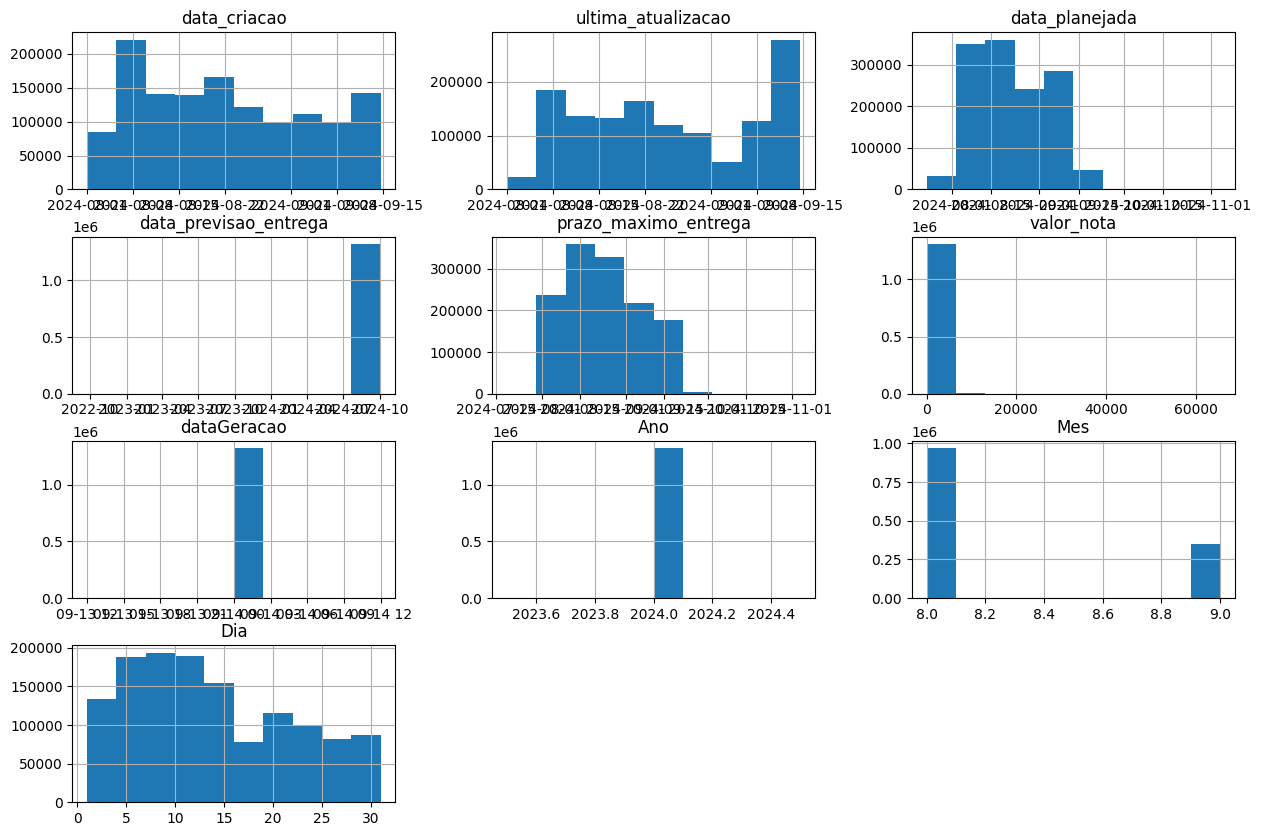

In [27]:
# Histograma
df_pandas.hist(figsize = (15,10))
# plt.show()

In [28]:
# Density Plot
df_pandas.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))

ValueError: Layout of 3x3 must be larger than required size 10

<Figure size 1500x1000 with 0 Axes>